# Human-Mammalian Brain - Basal Ganglia 10X snRANSeq analysis: gene expression

In this notebook we'll explore some gene expressions and combine them with the cell metadata we showed in the [previous clustering analysis](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html) tutorial.

You need to be connected to the internet to run this notebook or connected to a cache that has the Human-Mammalian Brain Atlas - Basal Ganglia (HMBA-BG) data downloaded already.

The notebook presented here shows quick visualizations from precomputed metadata in the atlas. For examples on accessing the expression matrices, specifically selecting genes from expression matrices, see the [general Accessing expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Optional

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache
from abc_atlas_access.abc_atlas_cache.anndata_utils import get_gene_data

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requested data on disk. For metadata, the cache can also directly serve up a Pandas DataFrame. See the [``getting_started``](https://alleninstitute.github.io/abc_atlas_access/notebooks/getting_started.html) notebook for more details on using the cache including installing it if it has not already been. 

**Change the download_base variable to where you would like to download the data to your system.**

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_cache_dir(
    download_base,
)

abc_cache.list_manifest_file_names.append('releases/20250930/manifest.json')
abc_cache.load_manifest('releases/20250930/manifest.json')
abc_cache.current_manifest

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:665: UserWarning: The manifest version recorded as last used for this cache -- releases/20250930/manifest.json-- is not a valid manifest for this dataset. Loading latest version -- releases/20250531/manifest.json -- instead.
  warnings.warn(msg, UserWarning)
/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:697: OutdatedManifestWarning: You are loading
releases/20250531/manifest.json
which is newer than the most recent manifest file you have previously been working with
releases/20250930/manifest.json
It is possible that some data files have changed between these two data releases, which will force you to re-download those data files (currently downloaded files will not be overwritten). To continue using releases/20250930/manifest.json, run
type.load_manifest('releases/20250930/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


'releases/20250930/manifest.json'

Create the expanded cell metadata as was done previously in the [cluster annotation tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html) tutorial.

In [3]:
# Load the cell metadata.
cell = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='cell_metadata',
    dtype={'cell_label': str}
).set_index('cell_label')
donor = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='donor'
).set_index('donor_label')
library = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='library'
).set_index('library_label')
value_sets = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='value_sets'
).set_index('label')

cell_extended = cell.join(donor, on='donor_label')
cell_extended = cell_extended.join(
    library, on='library_label',
    rsuffix='_library_table'
)

def extract_value_set(cell_metadata_df: pd.DataFrame, input_value_set: pd.DataFrame, input_value_set_label: str):
    """Add color and order columns to the cell metadata dataframe based on the input
    value set.

    Columns are added as {input_value_set_label}_color and {input_value_set_label}_order.

    Parameters
    ----------
    cell_metadata_df : pd.DataFrame
        DataFrame containing cell metadata.
    input_value_set : pd.DataFrame
        DataFrame containing the value set information.
    input_value_set_label : str
        The the column name to extract color and order information for. will be added to the cell metadata.
    """
    cell_metadata_df[f'{input_value_set_label}_color'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['color_hex_triplet'].values
    cell_metadata_df[f'{input_value_set_label}_order'] = input_value_set[
        input_value_set['field'] == input_value_set_label
    ].loc[cell_metadata_df[input_value_set_label]]['order'].values

extract_value_set(cell_extended, value_sets, 'region_of_interest_label')
extract_value_set(cell_extended, value_sets, 'species_genus')
extract_value_set(cell_extended, value_sets, 'species_scientific_name')
extract_value_set(cell_extended, value_sets, 'donor_sex')

# Load the cluster memembership metadata and combine the data with the cell data.
cell_2d_embedding_coordinates = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_2d_embedding_coordinates'
).set_index('cell_label')
cell_extended = cell_extended.join(cell_2d_embedding_coordinates)
cell_extended = cell_extended.sample(frac=1)

cell_to_cluster_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cell_to_cluster_membership',
).set_index('cell_label')

cluster = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster',
    dtype={'number_of_cells': 'Int64'}
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')
cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

cluster_annotation_term = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term',
).rename(columns={'label': 'cluster_annotation_term_label'}).set_index('cluster_annotation_term_label')

cell_to_cluster_membership = cell_to_cluster_membership[cell_to_cluster_membership['cluster_label'].isin(cluster_annotation_term.index)]

cluster_to_cluster_annotation_membership = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_to_cluster_annotation_membership',
).set_index('cluster_annotation_term_label')
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(
    cluster.reset_index().set_index('cluster_alias')[['number_of_cells']],
    on='cluster_alias'
)
membership_with_cluster_info = cluster_to_cluster_annotation_membership.join(cluster_annotation_term, rsuffix='_anno_term').reset_index()
membership_groupby = membership_with_cluster_info.groupby(
    ['cluster_alias', 'cluster_annotation_term_set_name']
)

cluster_annotation_term_set = abc_cache.get_metadata_dataframe(
    directory='HMBA-BG-taxonomy-CCN20250428',
    file_name='cluster_annotation_term_set'
).rename(columns={'label': 'cluster_annotation_term_label'})

cluster_details = membership_groupby['cluster_annotation_term_name'].first().unstack()
cluster_order = membership_groupby['term_order'].first().unstack()
cluster_order.sort_values(['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'], inplace=True)
cluster_order.rename(
    columns={'Neighborhood': 'Neighborhood_order',
             'Class': 'Class_order',
             'Subclass': 'Subclass_order',
             'Group': 'Group_order',
             'Cluster': 'Cluster_order'},
    inplace=True
)

cluster_colors = membership_groupby['color_hex_triplet'].first().unstack()
cluster_colors = cluster_colors[cluster_annotation_term_set['name']]
cluster_colors.sort_values(
    ['Neighborhood', 'Class', 'Subclass', 'Group', 'Cluster'],
    inplace=True
)

cell_extended = cell_extended.join(cell_to_cluster_membership, how='inner')
cell_extended = cell_extended[~pd.isna(cell_extended['cluster_alias'])]
cell_extended = cell_extended.join(cluster_details, on='cluster_alias')
cell_extended = cell_extended.join(cluster_colors, on='cluster_alias', rsuffix='_color')
cell_extended = cell_extended.join(cluster_order, on='cluster_alias')

cell_extended.head(5)

/Users/chris.morrison/src/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/abc_project_cache.py:643: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


cell_barcode donor_label  \
cell_label                                                
GGTTATGGTGATTACG-1068_B07  GGTTATGGTGATTACG  Q21.26.002   
GCCTTTATCGTCAAGT-897_E03   GCCTTTATCGTCAAGT  H20.30.002   
CCCTTAATCGGCTATG-2305_E01  CCCTTAATCGGCTATG  H24.30.003   
ACATCATCATGCTCCC-2018_B01  ACATCATCATGCTCCC  H23.30.001   
TCGCCCATCGCTAAAC-1955_B06  TCGCCCATCGCTAAAC  H23.30.001   

                          barcoded_cell_sample_label       library_label  \
cell_label                                                                 
GGTTATGGTGATTACG-1068_B07                   1068_B07  L8XR_220210_02_C04   
GCCTTTATCGTCAAGT-897_E03                     897_E03  L8XR_211028_02_F09   
CCCTTAATCGGCTATG-2305_E01                   2305_E01  L8XR_240705_01_A06   
ACATCATCATGCTCCC-2018_B01                   2018_B01  L8XR_240111_01_F09   
TCGCCCATCGCTAAAC-1955_B06                   1955_B06  L8XR_231116_01_E07   

                                                   alignment_job_id  \
cell_label                                                            
GGTTATGGTGATTACG-1068_B07  3dcfc8f873b5cc75274575e4f4ee380b88e2c7eb   
GCCTTTATCGTCAAGT-897_E03   5184c19b9f90b2d0329ec6d7e4ba3febe51999ee   
CCCTTAATCGGCTATG-2305_E01  382c7182ad442711600f409f1c80c6e7349dac23   
ACATCATCATGCTCCC-2018_B01  3f8802c4845985e8290a1041514906b38de36452   
TCGCCCATCGCTAAAC-1955_B06  7880de83fcc27ca64b60593dc9f6079a498a20e6   

                           doublet_score  umi_count  \
cell_label                                            
GGTTATGGTGATTACG-1068_B07       0.180000    18871.0   
GCCTTTATCGTCAAGT-897_E03        0.000000     6304.0   
CCCTTAATCGGCTATG-2305_E01       0.110000    30997.0   
ACATCATCATGCTCCC-2018_B01       0.026667    52638.0   
TCGCCCATCGCTAAAC-1955_B06       0.010000     3042.0   

                                  feature_matrix_label  \
cell_label                                               
GGTTATGGTGATTACG-1068_B07  HMBA-10xMultiome-BG-Aligned   
GCCTTTATCGTCAAGT-897_E03   HMBA-10xMultiome-BG-Aligned   
CCCTTAATCGGCTATG-2305_E01  HMBA-10xMultiome-BG-Aligned   
ACATCATCATGCTCCC-2018_B01  HMBA-10xMultiome-BG-Aligned   
TCGCCCATCGCTAAAC-1955_B06  HMBA-10xMultiome-BG-Aligned   

                                         dataset_label  \
cell_label                                               
GGTTATGGTGATTACG-1068_B07  HMBA-10xMultiome-BG-Aligned   
GCCTTTATCGTCAAGT-897_E03   HMBA-10xMultiome-BG-Aligned   
CCCTTAATCGGCTATG-2305_E01  HMBA-10xMultiome-BG-Aligned   
ACATCATCATGCTCCC-2018_B01  HMBA-10xMultiome-BG-Aligned   
TCGCCCATCGCTAAAC-1955_B06  HMBA-10xMultiome-BG-Aligned   

                                                  abc_sample_id  ...  \
cell_label                                                       ...   
GGTTATGGTGATTACG-1068_B07  75533f3f-ef90-431d-a1d1-c716462d56b9  ...   
GCCTTTATCGTCAAGT-897_E03   4804e1c9-80da-4d4d-81ee-8874f284656a  ...   
CCCTTAATCGGCTATG-2305_E01  262a97ae-c07d-4177-a2e0-f23114193024  ...   
ACATCATCATGCTCCC-2018_B01  e99b87ef-b051-4226-bea2-3e6d46627d0e  ...   
TCGCCCATCGCTAAAC-1955_B06  8dc4ee4e-408d-4491-b24f-75e21890aeaa  ...   

                          Neighborhood_color Class_color Subclass_color  \
cell_label                                                                
GGTTATGGTGATTACG-1068_B07            #91f4bb     #7d0f09        #66750b   
GCCTTTATCGTCAAGT-897_E03             #a8afa5     #401e66        #401e66   
CCCTTAATCGGCTATG-2305_E01            #19613b     #d0b83c        #253c8c   
ACATCATCATGCTCCC-2018_B01            #19613b     #d0b83c        #1655f2   
TCGCCCATCGCTAAAC-1955_B06            #a8afa5     #594a26        #594a26   

                          Group_color Cluster_color  Class_order  \
cell_label                                                         
GGTTATGGTGATTACG-1068_B07     #54621f       #20e2f3            5   
GCCTTTATCGTCAAGT-897_E03      #195f8d       #238c7a            1   
CCCTTAATCGGCTATG-2305_E01     #aec7e8       #6ef0df           10   
ACATCATCATGCTCC

### Single cell transcriptomes

The ~2 million, 10X single cell dataset of HMBA-BG is available in two separate packages. The first contains a single aligned h5ad file containing ~16k genes that have been aligned across all species. We use this single aligned dataset in this notebook. The other package is split across each species with a separate h5ad file for each species. These individually containing roughly ~36k genes for each species.

Below we show some interactions with data from the 10X expression matrices in the HMBA-BG dataset. For a deeper dive into how to access specific gene data from the expression matrices, take a look at [general accessing expression data](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html) tutorial.  

First, we list the available metadata in the HMBA-BG 10X dataset again. 

In [4]:
abc_cache.list_metadata_files('HMBA-10xMultiome-BG-Aligned')

['cell_metadata',
 'donor',
 'example_gene_expression',
 'gene',
 'library',
 'value_sets']

For completeness, we list the available expression matrix files.

In [5]:
abc_cache.list_expression_matrix_files('HMBA-10xMultiome-BG-Aligned')

['HMBA-10xMultiome-BG-Aligned/log2', 'HMBA-10xMultiome-BG-Aligned/raw']

We first load the gene data for the Aligned dataset covering all species in the BG dataset.

In [6]:
aligned_gene = abc_cache.get_metadata_dataframe(
    directory='HMBA-10xMultiome-BG-Aligned',
    file_name='gene'
).set_index('gene_identifier')
print("Number of aligned genes = ", len(aligned_gene))
aligned_gene.head(5)

gene.csv: 100%|██████████| 1.15M/1.15M [00:00<00:00, 2.70MMB/s]


Number of aligned genes =  16630


gene_symbol  \
gene_identifier               
NCBIGene:9380         GRHPR   
NCBIGene:6603       SMARCD2   
NCBIGene:148103      ZNF599   
NCBIGene:92691      TMEM169   
NCBIGene:3235         HOXD9   

                                                       description  \
gene_identifier                                                      
NCBIGene:9380             glyoxylate and hydroxypyruvate reductase   
NCBIGene:6603    SWI/SNF related, matrix associated, actin depe...   
NCBIGene:148103                            zinc finger protein 599   
NCBIGene:92691                           transmembrane protein 169   
NCBIGene:3235                                          homeobox D9   

                 molecular_type  
gene_identifier                  
NCBIGene:9380    protein-coding  
NCBIGene:6603    protein-coding  
NCBIGene:148103  protein-coding  
NCBIGene:92691   protein-coding  
NCBIGene:3235    protein-coding

Below we list the genes we will use in this notebook and the example method used to load the expression for these specific genes from the h5ad file. Note that we provide a set of example gene expressions as a csv file for brevity in this tutorial. To process and extract the gene expressions for yourself, uncomment the code block below. More details on how to extract specific genes from the data see our [accessing gene expression data tutorial](https://alleninstitute.github.io/abc_atlas_access/notebooks/general_accessing_10x_snRNASeq_tutorial.html)

In [7]:
gene_names = ['SLC17A6', 'SLC32A1', 'PTPRC', 'PLP1', 'AQP4', 'DRD1', 'DRD2']

"""
aligned_gene_data = get_gene_data(
    abc_atlas_cache=abc_cache,
    all_cells=cell_extended,
    all_genes=aligned_gene,
    selected_genes=gene_names
)
"""

'\naligned_gene_data = get_gene_data(\n    abc_atlas_cache=abc_cache,\n    all_cells=cell_extended,\n    all_genes=aligned_gene,\n    selected_genes=gene_names\n)\n'

Instead of processing the gene expressions, we load a pre-processed file.

In [8]:
aligned_gene_data = abc_cache.get_metadata_dataframe(
    'HMBA-10xMultiome-BG-Aligned',
    'example_gene_expression'
).set_index('cell_label')

example_gene_expression.csv: 100%|██████████| 135M/135M [00:47<00:00, 2.84MMB/s]   


Next, we'll concatenate the gene data together and merge them into our cell metadata. 

In [9]:
cell_extended_with_genes = cell_extended.join(aligned_gene_data)

## Example use cases

In this section, we show a use case with the example genes *SLC17A6*, *SLC32A1*, *PTPRC*, *PLP1*, *AQP4*, *DRD1*, and *DRD2*. These genes were selected because they are marker genes for glutamatergic (*SLC17A6*) and GABAergic (*SLC32A1*) neurons, immune cells (*PTPRC*), oligodendrocytes (*PLP1*), astrocytes (*AQP4*), and D1/D2 medium spiny neurons (*DRD1*, *DRD2*).  "Marker genes" have much higher expression in the specified cell type or anatomic structure when compared to all other cells, and in many cases are functionally relevant for those cell types.

The helper function below creates a heatmap showing the relation between various parameters in the combined cell metadata and the genes we loaded.

In [10]:
import matplotlib as mpl


def plot_species_heatmap(
    df: pd.DataFrame,
    gnames: List[str],
    value: str,
    species_list: List[str] = None,
    sort: bool = False,
    fig_width: float = 8,
    fig_height: float = 4,
    vmax: float = None,
    cmap: plt.cm = plt.cm.magma_r
):
    """Plot a heatmap of gene expression values for a list of genes across species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata and gene expression values.
    gnames : list
        List of gene names to plot.
    value : str
        Column name in df to group by (e.g., 'species_genus').
    species_list : list, optional
        List of species to include in the plot. If None, all unique species in df are used.
    sort : bool, optional
        Whether to sort the gene expression values within each species.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    vmax : float, optional
        Maximum value for the color scale. If None, it is set to the maximum value in the data.
    cmap : matplotlib colormap, optional
        Colormap to use for the heatmap.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the heatmap.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_unique_values = df[value].unique()

    try:
        order = df[f'{value}_order'].unique()
        all_unique_values = all_unique_values[np.argsort(order)]
    except KeyError:
        order = None

    all_grouped = df.groupby(value)[gnames].mean()
    vmin = all_grouped.min().min()
    vmax = all_grouped.max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    for idx, species in enumerate(species_list):
        
        filtered = df[df['species_genus'] == species]
        
        grouped = filtered.groupby(value)[gnames].mean()
        if sort:
            grouped = grouped.sort_values(by=gnames[0], ascending=False)

        missing_values = []
        indices = []
        for unique_value in all_unique_values:
            if unique_value not in grouped.index:        
                indices.append(unique_value)
                missing_values.append({key: np.nan for key in gnames})

        if missing_values:
            grouped = pd.concat([grouped, pd.DataFrame(data=missing_values, index=indices)])
        grouped = grouped.loc[all_unique_values]

        arr = grouped.to_numpy().astype('float')

        ax[idx].imshow(arr, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
        xlabs = grouped.columns.values
        ylabs = grouped.index.values

        if idx == 0:
            ax[idx].set_yticks(range(len(ylabs)))
            ax[idx].set_yticklabels(ylabs)
        else:
            ax[idx].set_yticks([])
            ax[idx].set_yticklabels([])
        ax[idx].set_xticks(range(len(xlabs)))
        ax[idx].set_xticklabels(xlabs)
        ax[idx].set_title(species)

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('Mean Expression [log2(CPM + 1)]')
    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    
    return fig, ax

### Expression of selected genes in the Basal Ganglia

Below we use our heatmap function to plot the gene expression as a function of a feature in our data. For the first two plots, we show the expression for all species against the Neighborhood and Group levels of the taxonomy. Note that a band of white denotes a Group (or other feature) that is not present in for the given species.

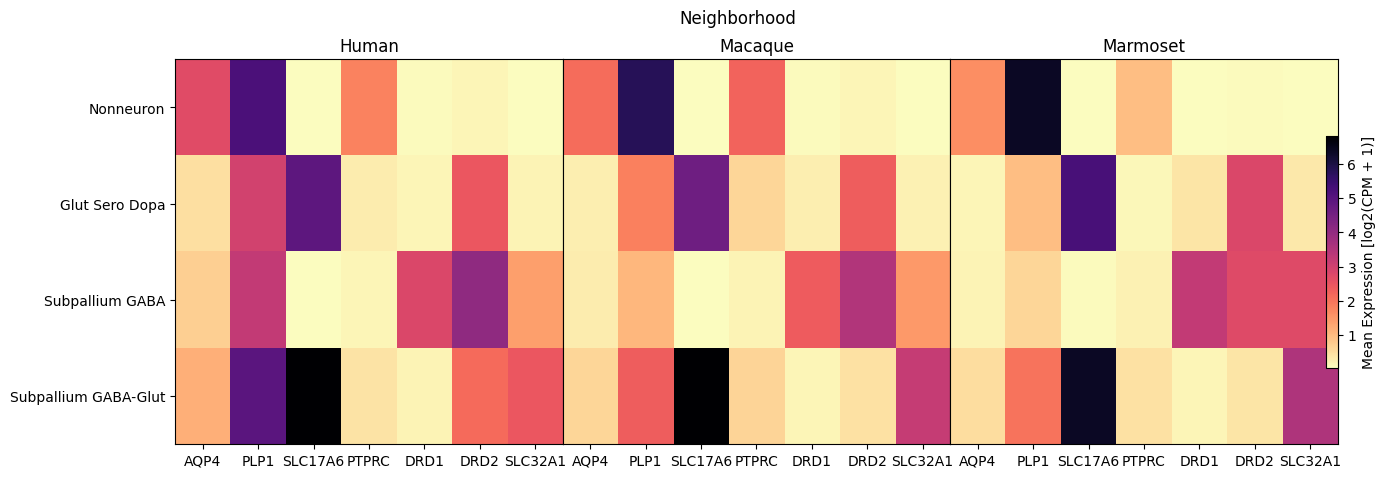

In [11]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='Neighborhood',
    species_list=['Human', 'Macaque', 'Marmoset'],
    fig_width=15,
    fig_height=5
)
fig.suptitle('Neighborhood')
plt.show()

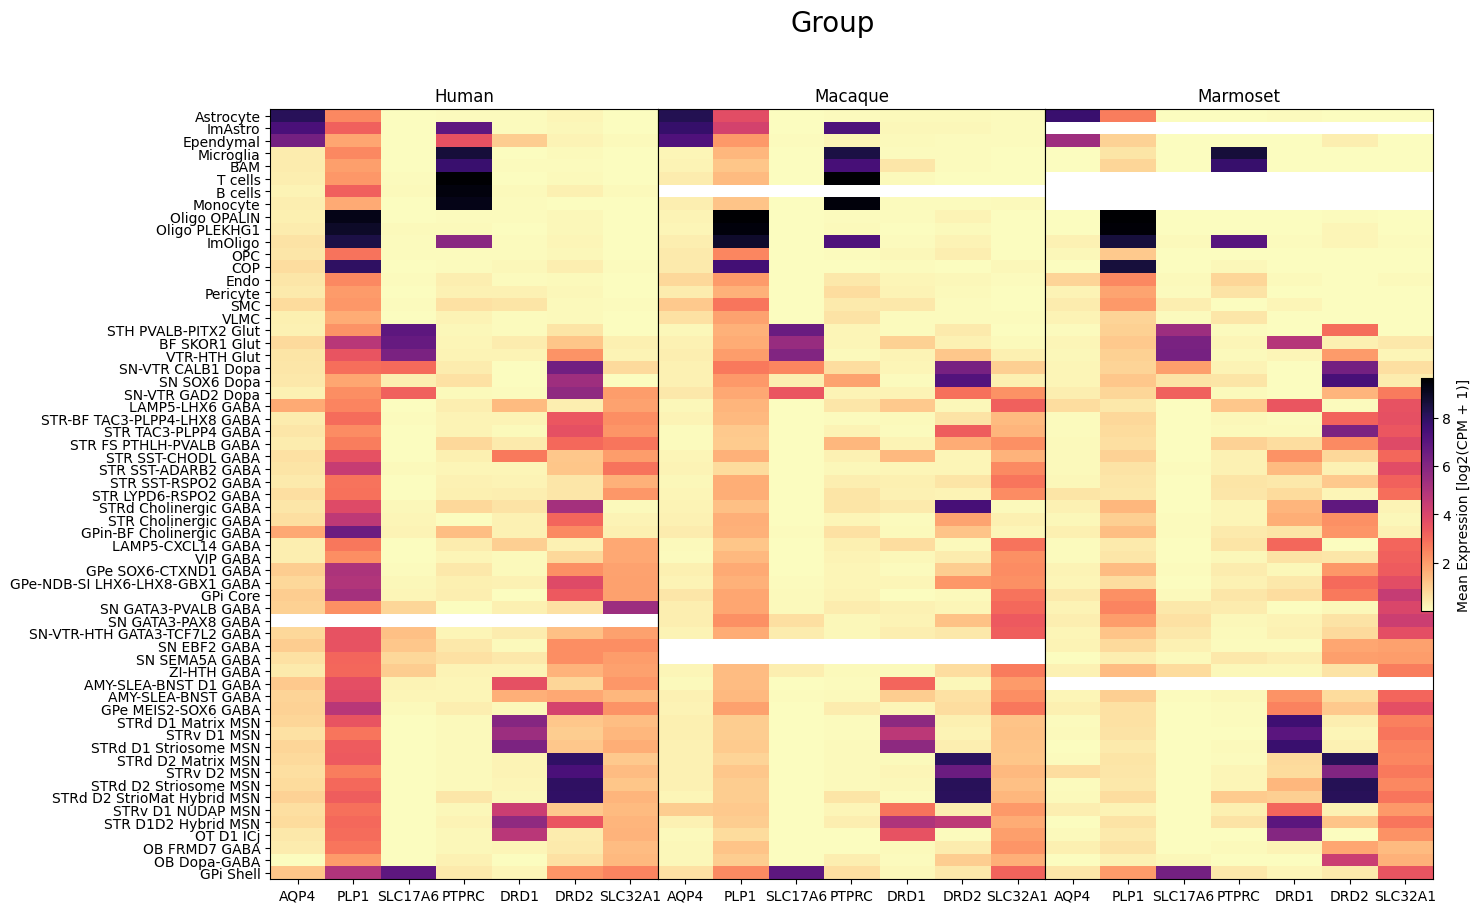

In [12]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    value='Group',
    species_list=['Human', 'Macaque', 'Marmoset'],
    fig_width=15,
    fig_height=10
)
fig.suptitle('Group', size=20)
plt.show()

Now we perform the same heatmap comparison against the region of interest in the brain the cell was extracted from. Note that currently the Marmoset has no fine grained identification of brain region.

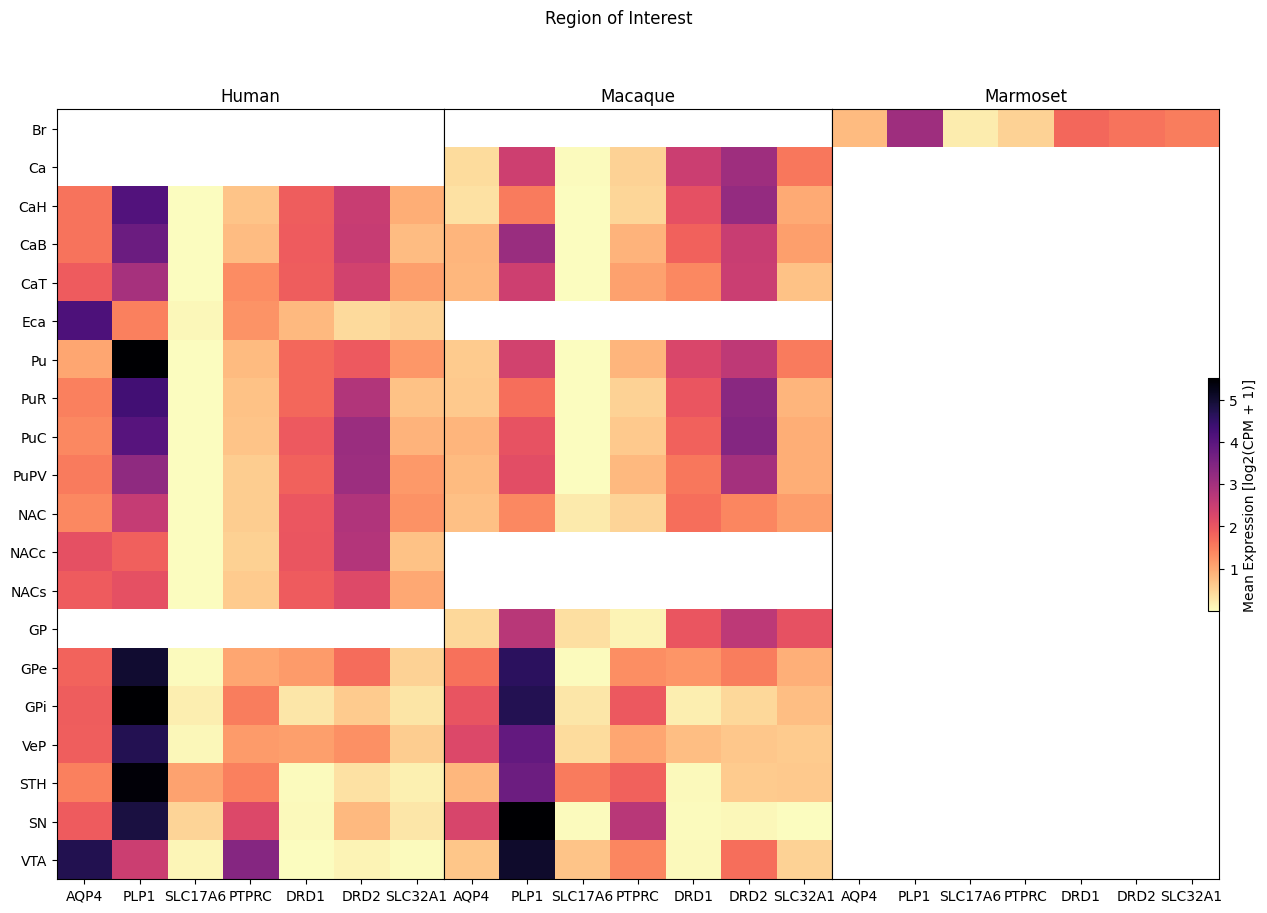

In [13]:
fig, ax = plot_species_heatmap(
    df=cell_extended_with_genes,
    gnames=aligned_gene_data.columns,
    species_list=['Human', 'Macaque', 'Marmoset'],
    value='region_of_interest_label',
    fig_width=15,
    fig_height=10
)
fig.suptitle('Region of Interest')
plt.show()

## Expression in the UMAP

We can also visualize the relationship between these genes and their location in the UMAP. We'll plot the species side by side with the dark grey cells in each plot representing those from the other species that do not overlap with the plotted one. We select a minium expression value of which effectively masks out zero expression cells from the plots, showing a bit more contrast. The cells below are selected value are plotted as a light grey. Feel free to experiment with different vmin and vmax values in investigate the gene expressions more in depth.

In [14]:
def plot_umap(
        df: pd.DataFrame,
        feature: str,
        species_list: List[str],
        cmap=None,
        vmin: Optional[float] = None,
        vmax: Optional[float] = None,
        fig_width=21,
        fig_height=10
):
    """Plot UMAP scatter plots for a given feature across multiple species.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell metadata including 'x', 'y', and 'species_genus' columns.
    feature : str
        Column name in df to color the points by (e.g., gene expression).
    species_list : list
        List of species to include in the plot.
    cmap : matplotlib colormap, optional
        Colormap to use for coloring the points. If None, uses the feature values as colors directly.
    vmin: float, optional
        Minimum value for color mapping. Defaults to min of values in the feature column. Cells with
        expression below this value will be plotted as light grey.
    vmax: float, optional
        Maximum value for color mapping. Defaults to max of values in the feature column.  Cells with
        expression above this value will be plotted as light grey.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
        

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object containing the UMAP plots.
    ax : array of matplotlib.axes.Axes
        The axes objects for each species.
    """

    fig, ax = plt.subplots(1, len(species_list))
    fig.set_size_inches(fig_width, fig_height)

    all_xx = df['x']
    all_yy = df['y']

    vv = df[feature]
    if vmin is None:
        vmin = vv.min()

    if vmax is None:
        vmax = vv.max()

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cmap = sm.get_cmap()

    for idx, species in enumerate(species_list):

        species_mask = df['species_genus'] == species
        filtered = df[species_mask]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]
        ax[idx].scatter(all_xx, all_yy, s=1.0, color='#636363', marker='.', label='Other Species')

        if cmap is not None:
            mask = np.logical_and(vv >= vmin, vv <= vmax)
            if mask.any():
                ax[idx].scatter(xx[~mask], yy[~mask], s=1.0, c='#D3D3D3', marker='.')
                ax[idx].scatter(xx[mask], yy[mask], s=1.0, c=vv[mask], marker='.', cmap=cmap)
            else:
                ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")
        else :
            ax[idx].scatter(xx, yy, s=1.0, color=vv, marker=".")

        ax[idx].axis('equal')
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title(f"{species}")
    
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.01, pad=0.01)
    cbar.set_label('[log2(CPM + 1)]')

    plt.legend(loc=0, markerscale=10)
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax

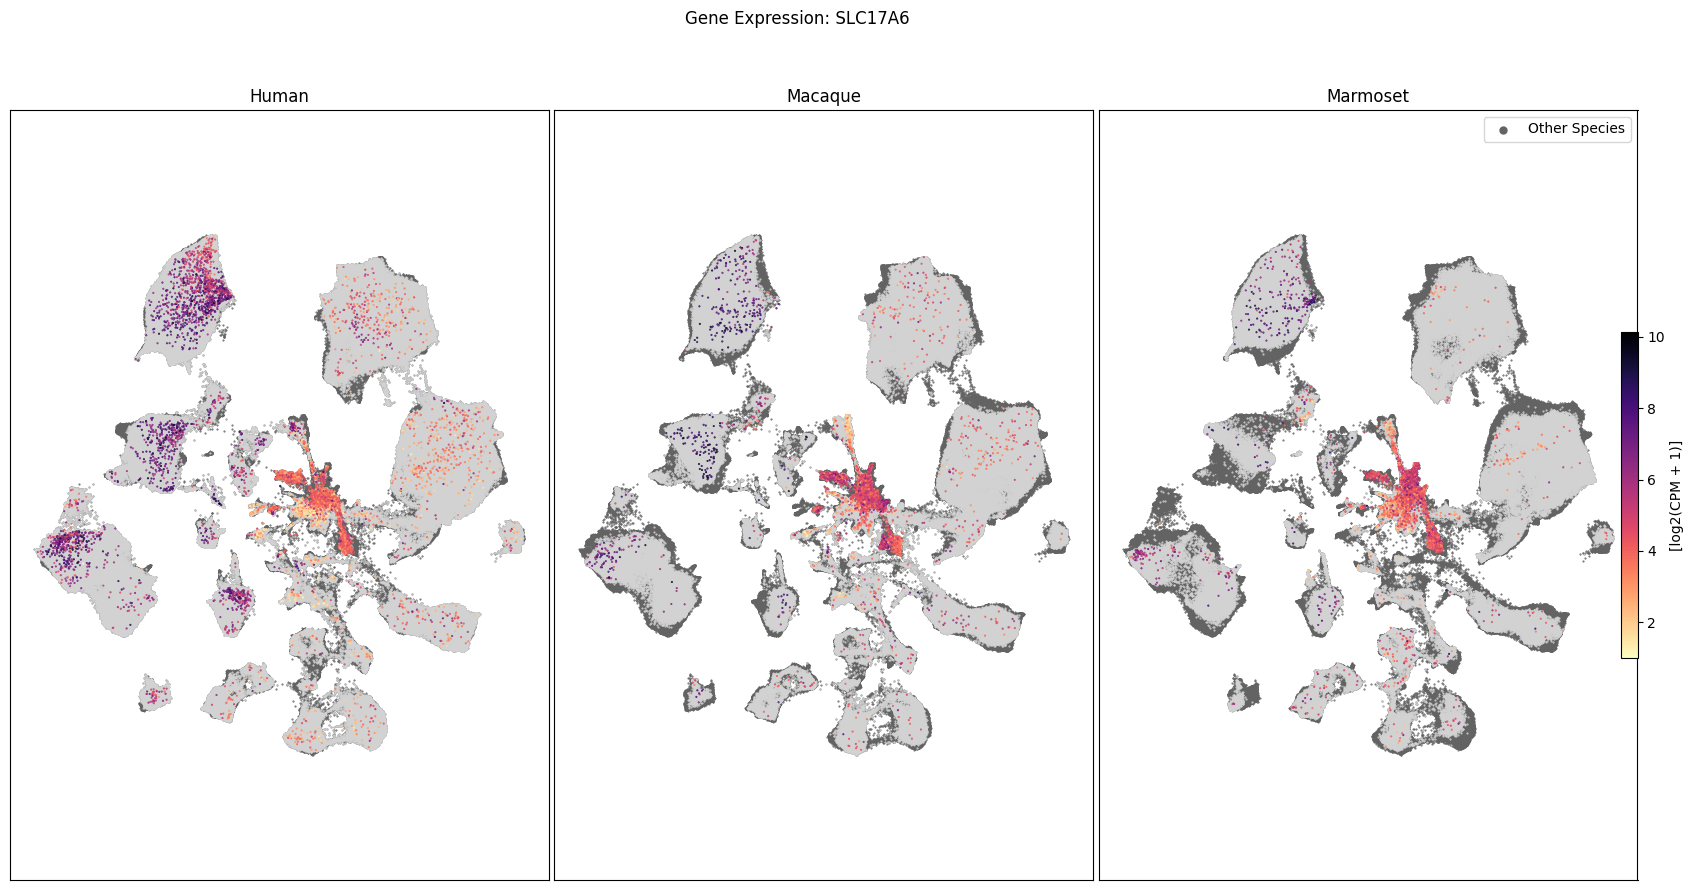

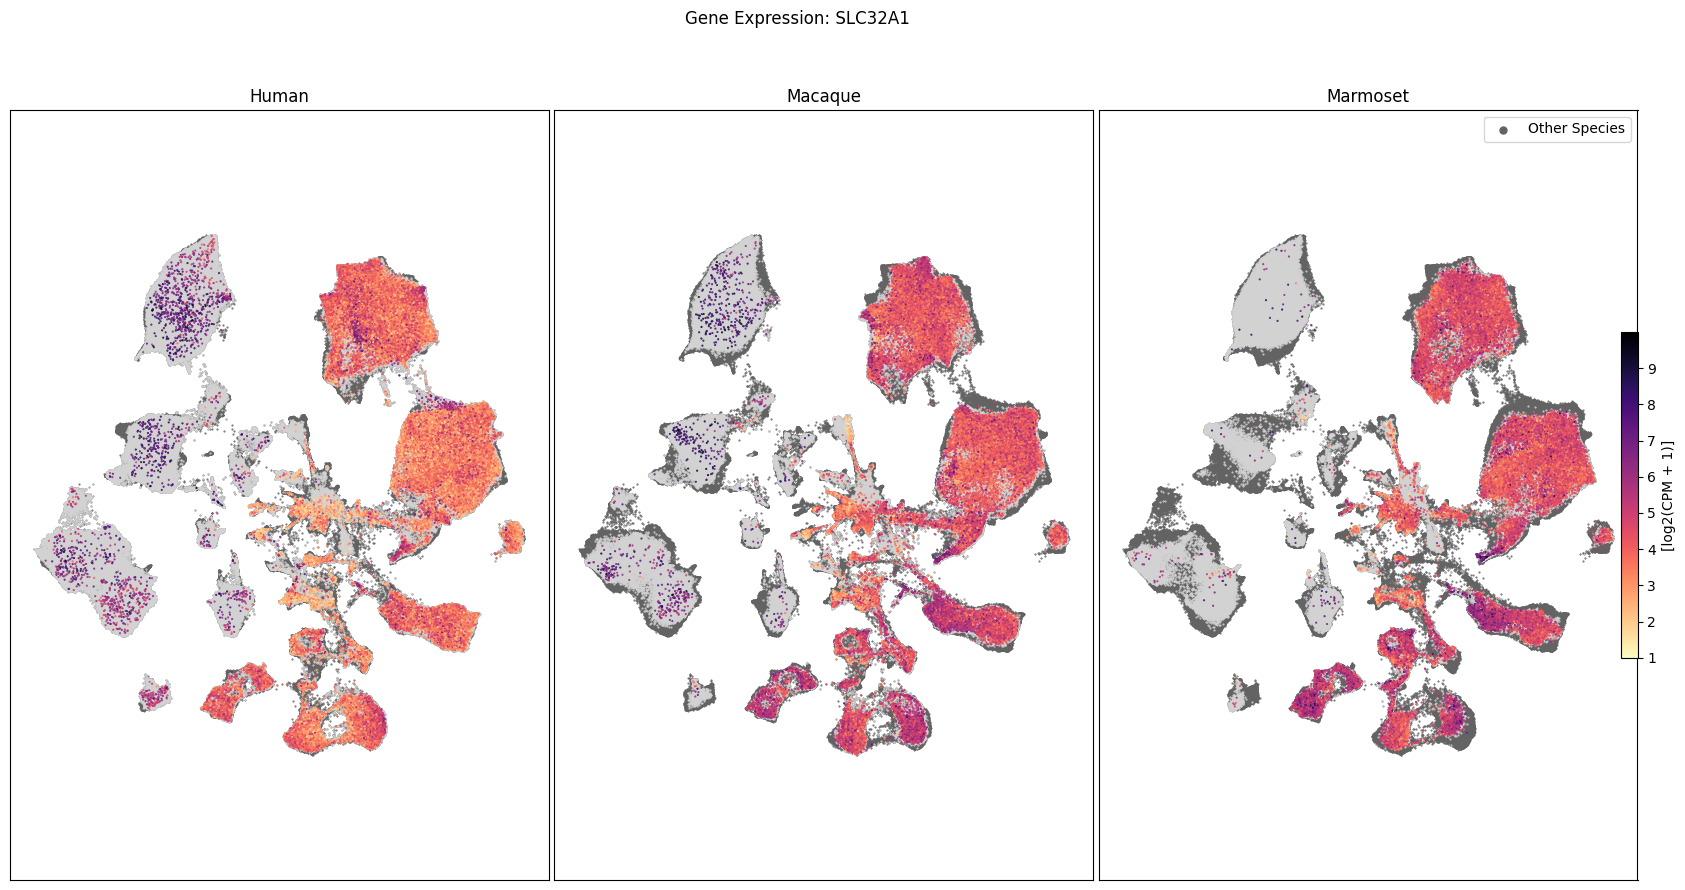

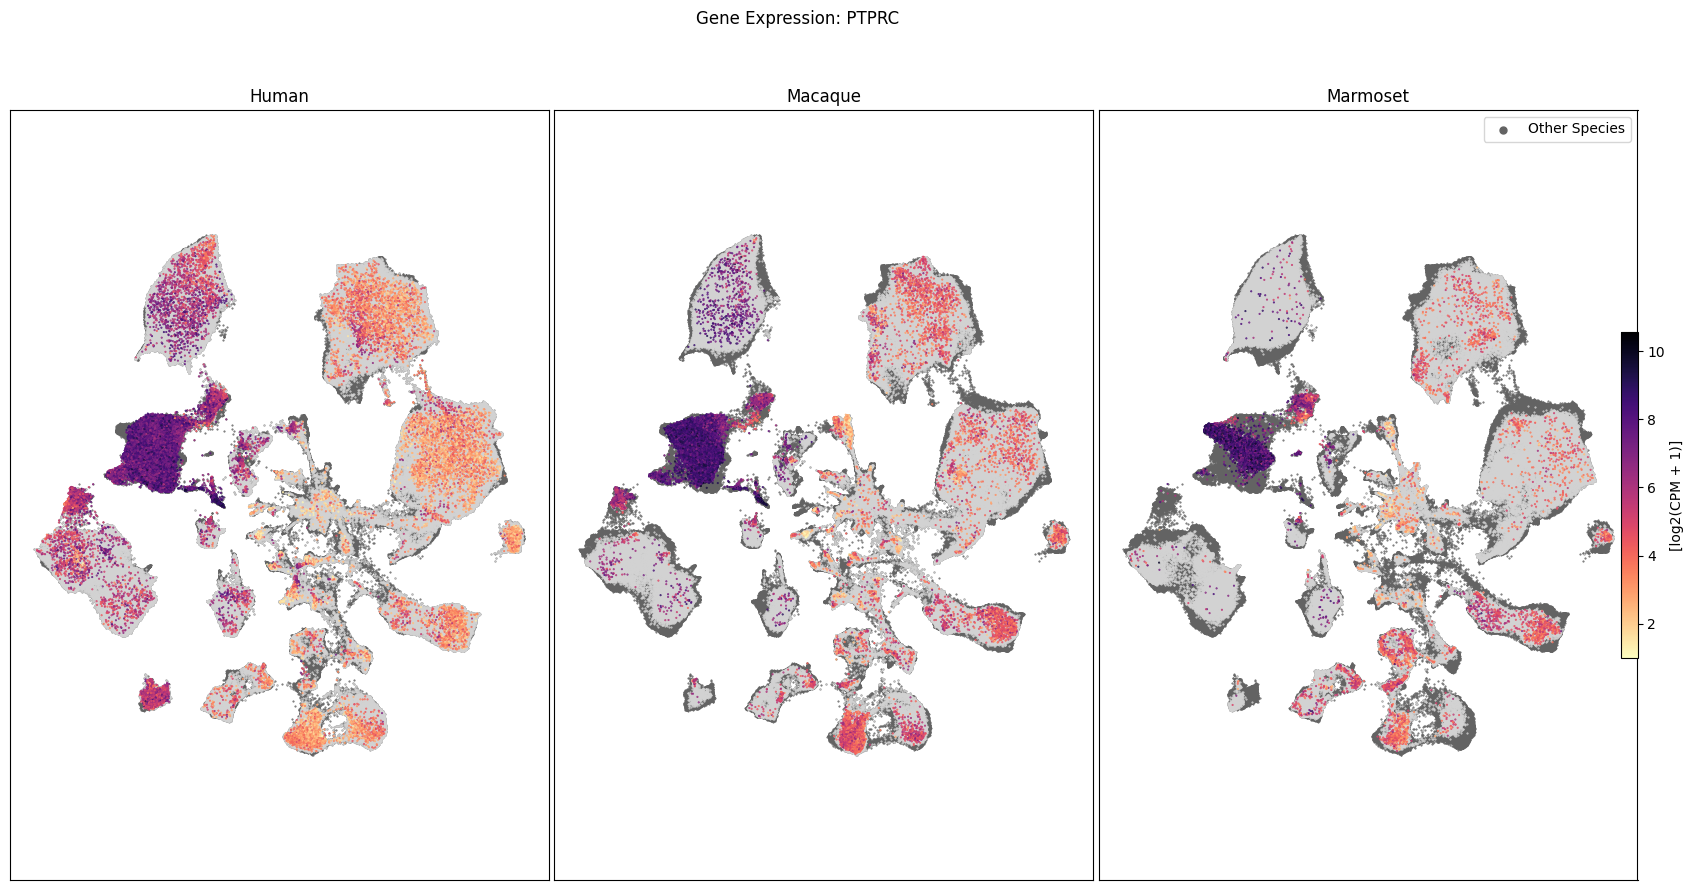

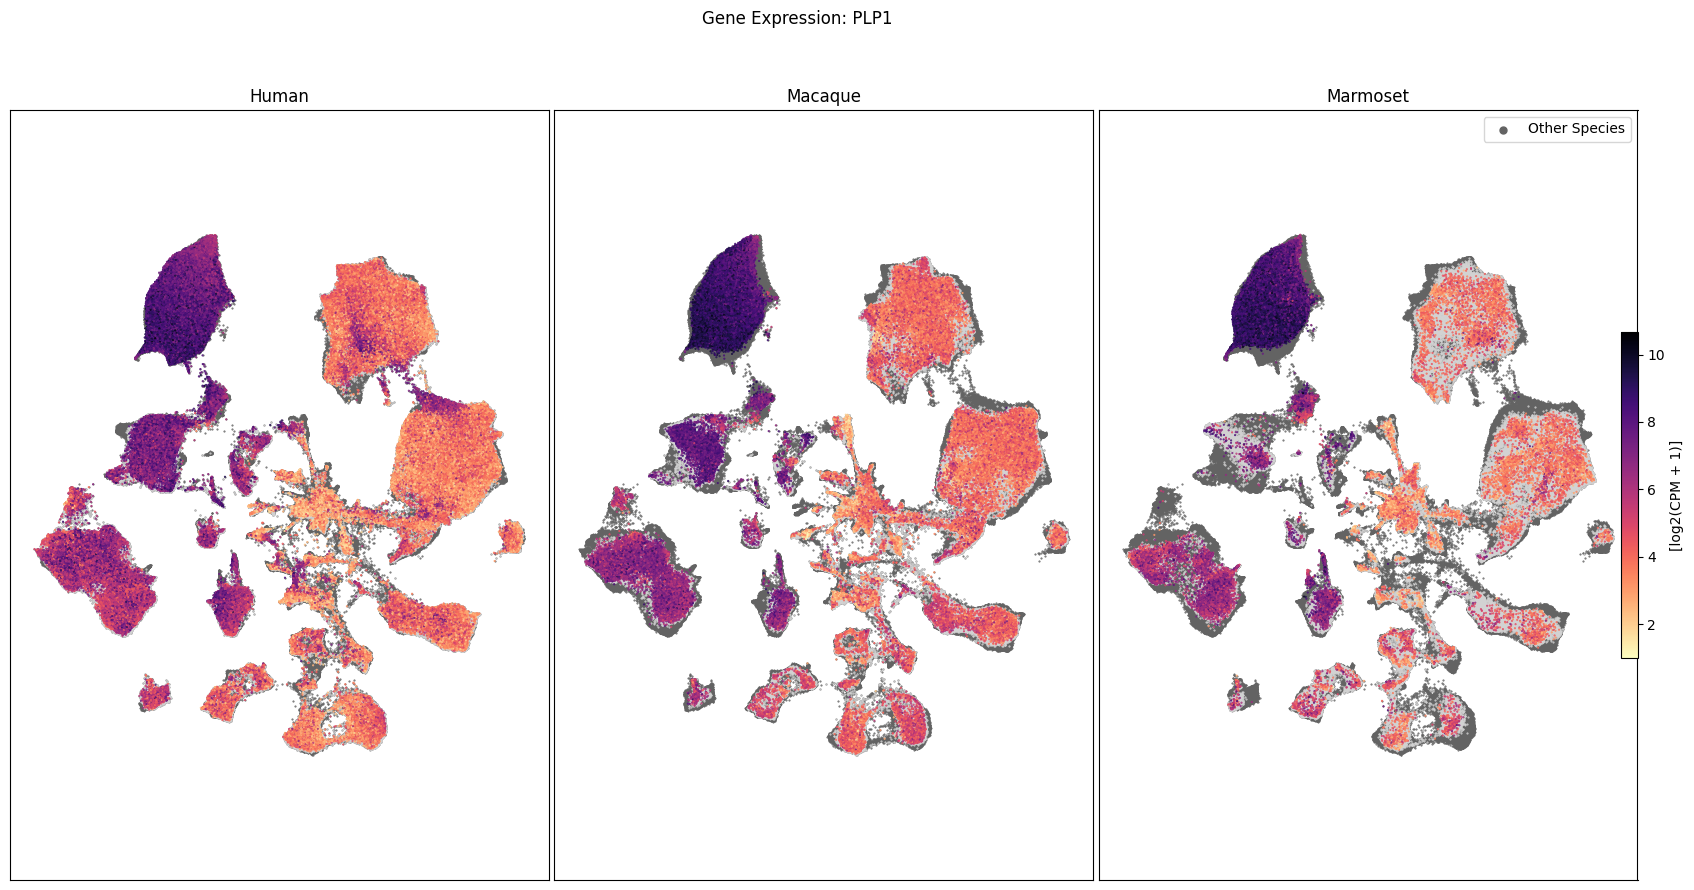

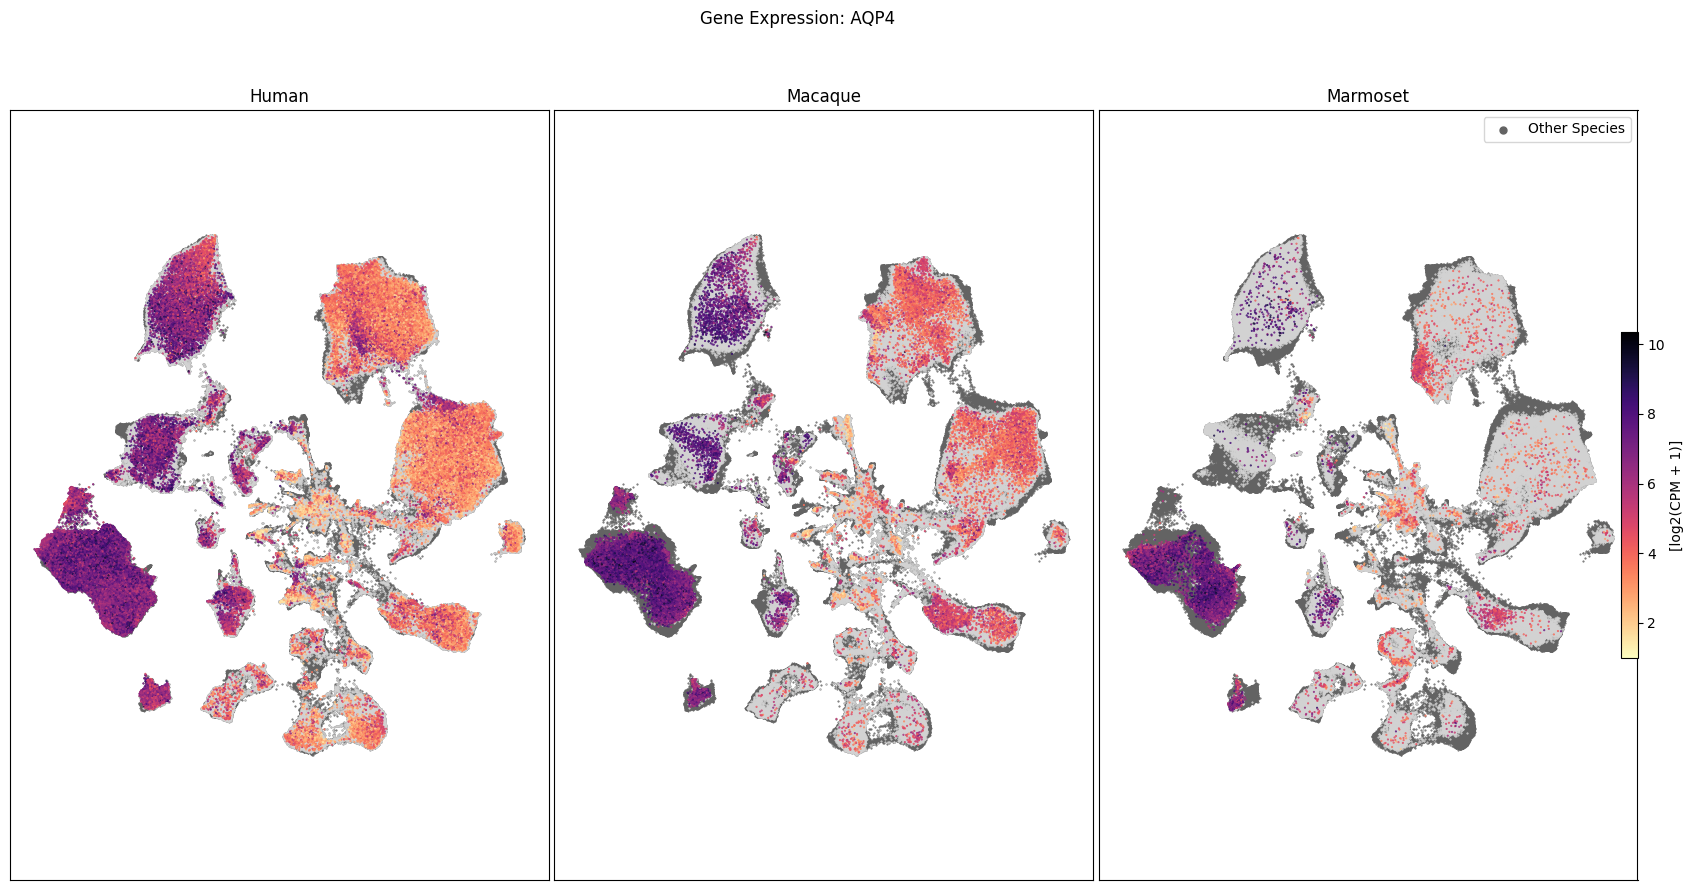

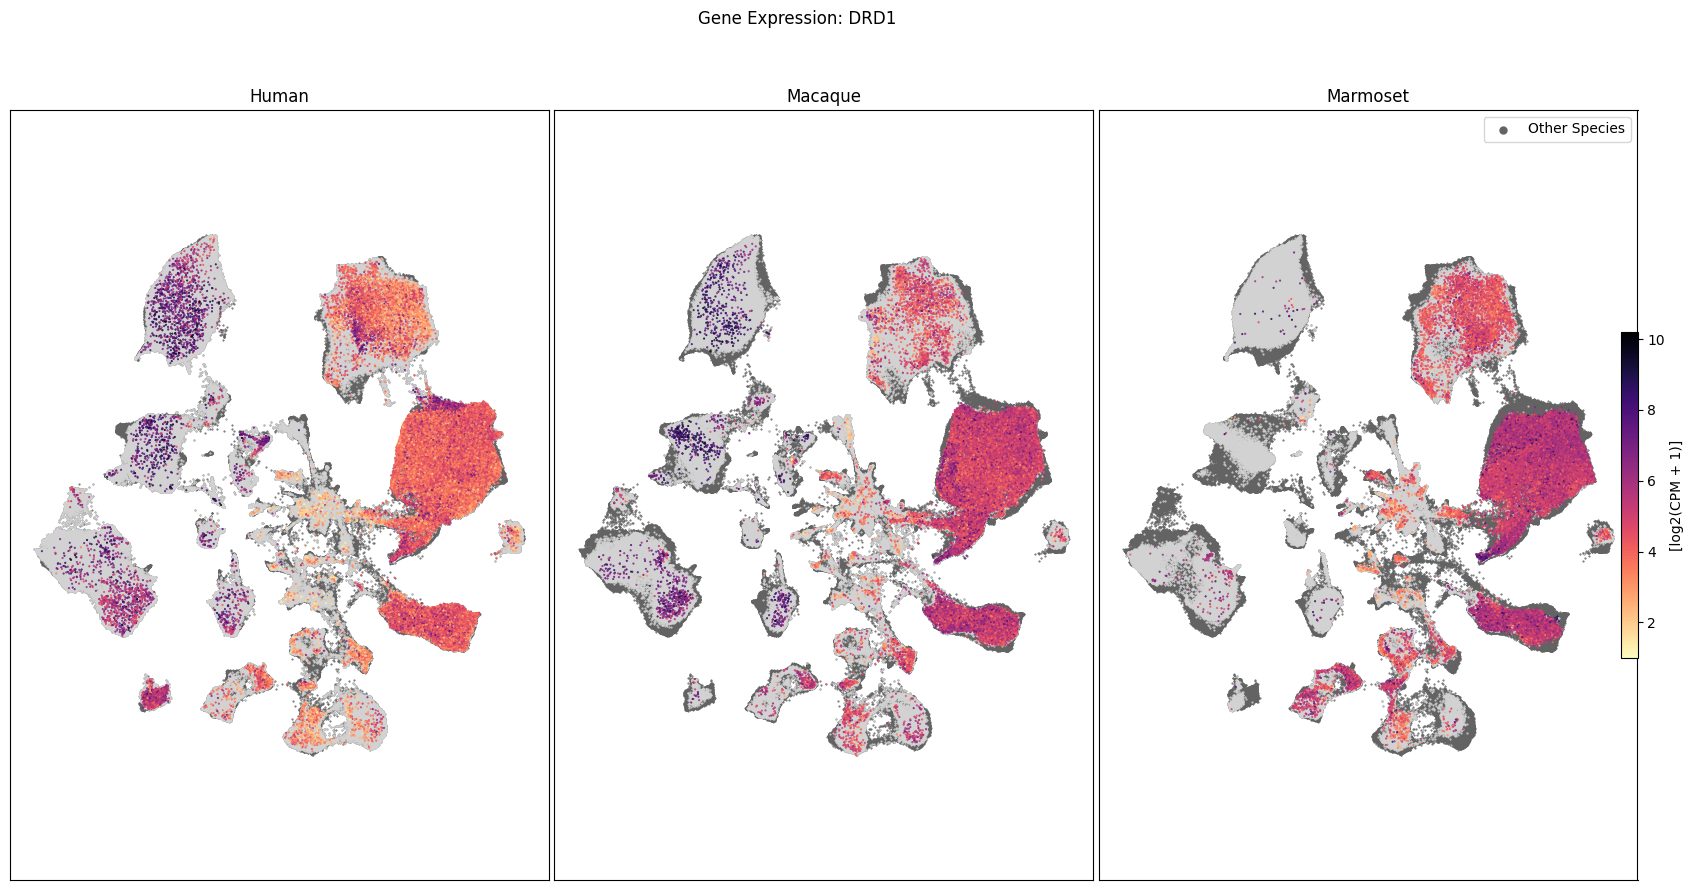

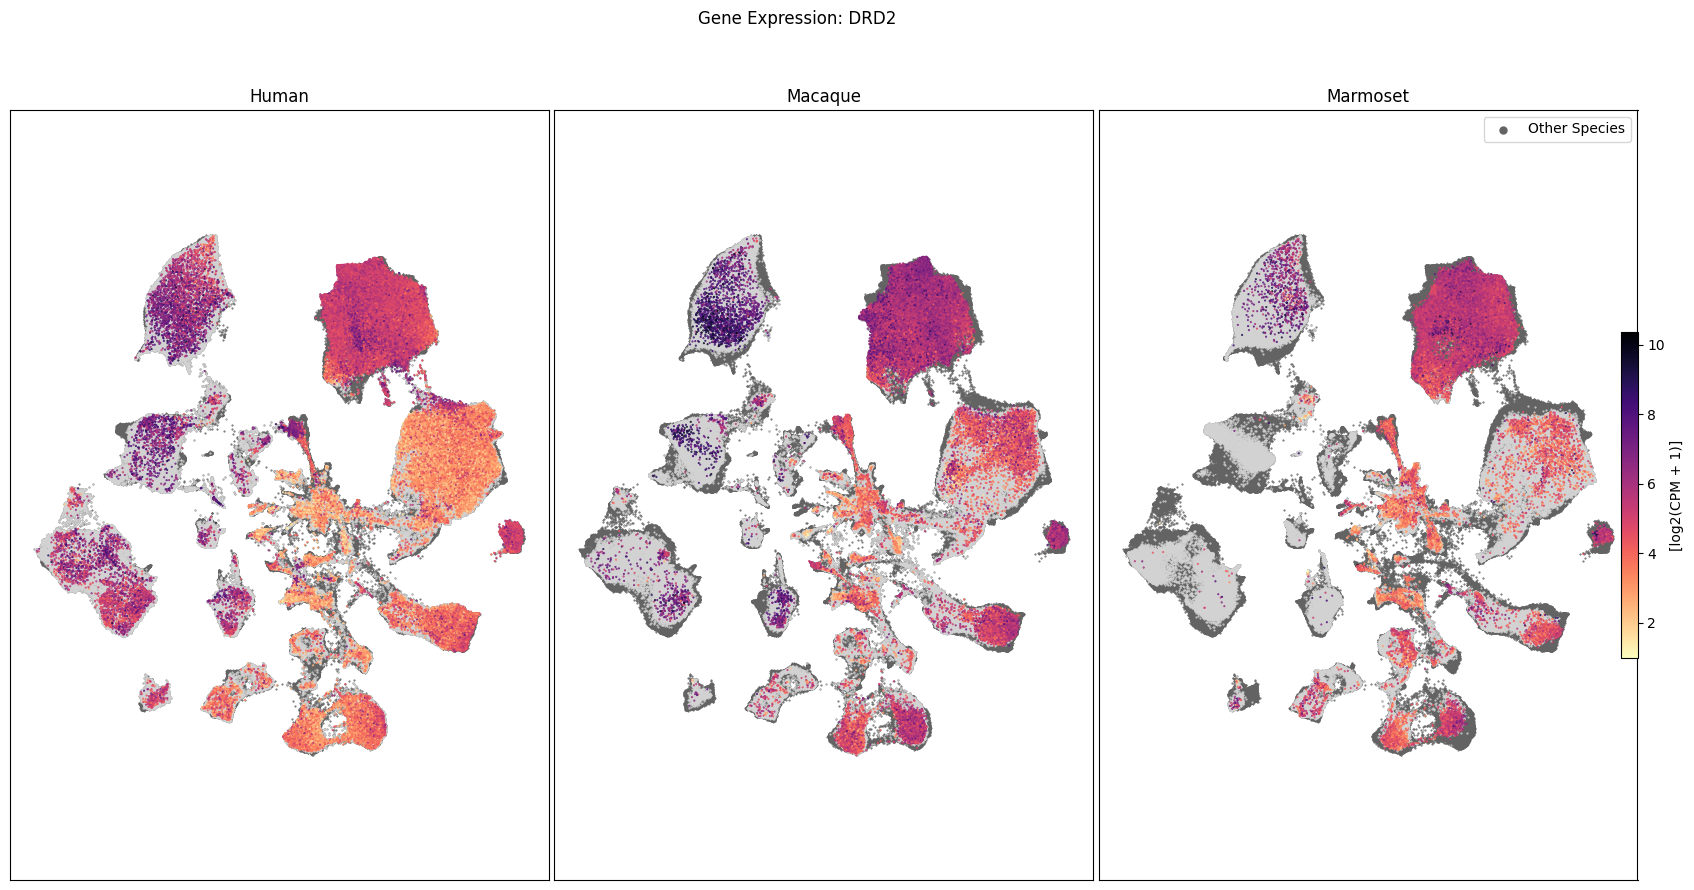

In [15]:
for gene_name in gene_names:
    fig, ax = plot_umap(
        cell_extended_with_genes,
        feature=gene_name,
        species_list=['Human', 'Macaque', 'Marmoset'],
        cmap=plt.cm.magma_r,
        vmin=1,
        vmax=None
    )
    fig.suptitle(f'Gene Expression: {gene_name}')
    plt.show()

To learn more about the taxonomy and metadata used in this notebook see the [HMBA-BG Clustering Analysis and Taxonomy notebook](https://alleninstitute.github.io/abc_atlas_access/notebooks/hmba_bg_clustering_analysis_and_annotation.html).